In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
import psyneulink as pnl
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas

import sys; sys.path.append('./shape-naming/')
import shape_naming_model

## Plotting utility

In [3]:
DEFAULT_FIGURE_SIZE = (18, 10)
DEFAULT_TITLES = ('72 epochs', '504 epochs', '2520 epochs')
ORDERED_KEYS = ('control', 'conflict', 'congruent')

def plot_by_condition(first_results, second_results=None, third_results=None,
                     figsize=DEFAULT_FIGURE_SIZE, titles=DEFAULT_TITLES,
                     ordered_keys=ORDERED_KEYS):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=DEFAULT_FIGURE_SIZE)
    fig.patch.set_facecolor('#DDDDDD')
    fig.suptitle('Figure 12', fontsize=24)

    plot_single_result_set(ax1, first_results, titles[0], ordered_keys)
    if second_results is not None: 
        plot_single_result_set(ax2, second_results, titles[1], ordered_keys)
    if third_results is not None:
        plot_single_result_set(ax3, third_results, titles[2], ordered_keys)
    
    plt.show()
    
def plot_single_result_set(ax, results, title, ordered_keys):
    shape_naming, color_naming, _ = results
    shape_naming_avg = [np.average(shape_naming[key]) for key in ordered_keys]
    shape_naming_std = [np.std(shape_naming[key]) for key in ordered_keys]
    
    color_naming_avg = [np.average(color_naming[key]) for key in ordered_keys]
    color_naming_std = [np.std(color_naming[key]) for key in ordered_keys]
    x_values = np.arange(3)
                                  
    ax.errorbar(x_values, shape_naming_avg, yerr=shape_naming_std, marker='o', 
                markersize=10, capsize=10, label='shape')
    ax.errorbar(x_values, color_naming_avg, yerr=color_naming_std, marker='s', 
                markersize=10, capsize=10, label='color')

    ax.set_xticks(x_values)
    ax.set_xticklabels(ordered_keys)
    ax.tick_params(length=15, labelsize=16)
    ax.legend(fontsize=16)
    ax.set_title(title, dict(fontsize=16))

## Training utilities

In [4]:
def train_and_test(model, num_train=1):
    for _ in range(num_train):
        model.train()
    
    return model.test()


def day_one(model):
    return train_and_test(model)


def day_five(model):
    return train_and_test(model, 4)


def day_twenty(model):
    return train_and_test(model, 26)

## First day

Create the model, train it on a day's worth of stimuli, test, plot the results

In [4]:
model = shape_naming_model.ShapeNamingModel(2)

In [34]:
# model.system.show_graph(show_dimensions=pnl.ALL, show_projection_labels=pnl.ALL, show_processes=pnl.ALL, show_mechanism_structure=pnl.ALL, output_fmt='jupyter')

In [6]:
first_day_train = model.train()

In [7]:
first_test_results = model.test()

In [8]:
shape_naming_results, color_naming_results, run_shape_naming_first = first_test_results

In [9]:
print('Shape-naming')
for key in shape_naming_results:
    print(key, np.average(shape_naming_results[key]))
print()
print('Color-naming')
for key in shape_naming_results:
    print(key, np.average(color_naming_results[key]))

Shape-naming
control 59.9375
congruent 66.20833333333333
conflict 67.02083333333333

Color-naming
control 38.208333333333336
congruent 40.0
conflict 36.0625


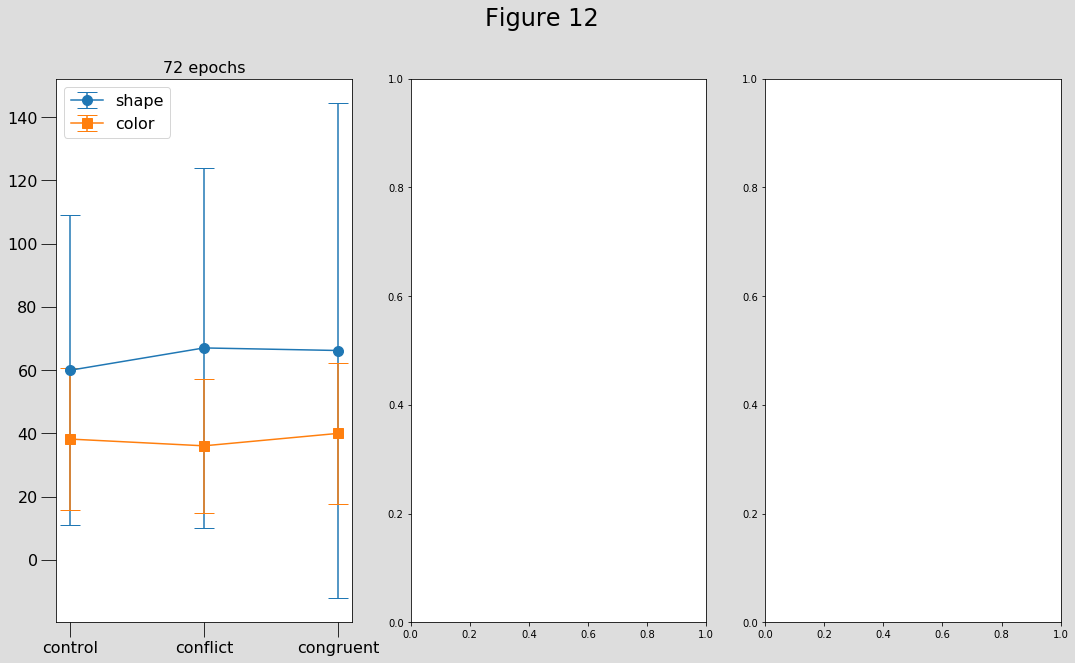

In [35]:
plot_by_condition(first_test_results)


## Train for another four days worth of training

This arrives at a total of 504 epochs, if my math is right

In [11]:
for i in range(4):
    model.train()

Test again, and then plot again

In [12]:
five_day_test_results = model.test()

In [13]:
five_day_shape_naming_results, five_day_color_naming_results, five_day_run_shape_naming_first = five_day_test_results

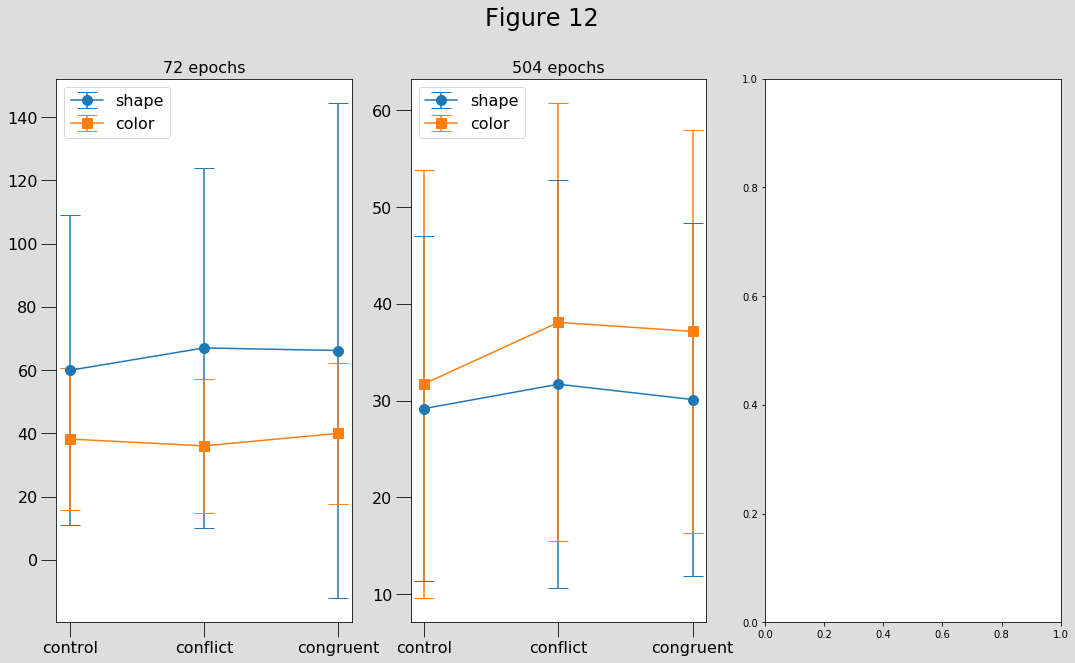

In [36]:
plot_by_condition(first_test_results, five_day_test_results)


## This is odd

After 504 training iterations, the shape-naming is already better than color naming. Additionally, the control conition appears harder than confluct, which is quite strange.

### TODO:

* Try fixing the indirect path's weights and seeing what this looks like

* ~~Verify that the stimuli I generate are all the correct ones~~

    * I definitly had a bug. Rerunning everything above to see if that fixes some of it.
    
    * It does. At least by the 5 day iteration, it looks better. However, the shape still learns much faster than the control. Additionally, why does the color-naming get better? Nothing in that pathway should learn.

In [5]:
fixed_indirect_weights = shape_naming_model.DEFAULT_WEIGHT_DICT.copy()
fixed_indirect_weights[shape_naming_model.SHAPE_INDIRECT_KEY] = \
    np.matrix([[1, -1], [-1, 1]])

fixed_indirect_weights[shape_naming_model.INDIRECT_OUTPUT_KEY] = \
    np.matrix([[1, -1], [-1, 1]])

fixed_indirect_model = shape_naming_model.ShapeNamingModel(
    2, weight_dict=fixed_indirect_weights, indirect_learning_rate=0)

In [20]:
fixed_indirect_day_one_train = fixed_indirect_model.train()

In [22]:
fixed_indirect_first_test_results = fixed_indirect_model.test()

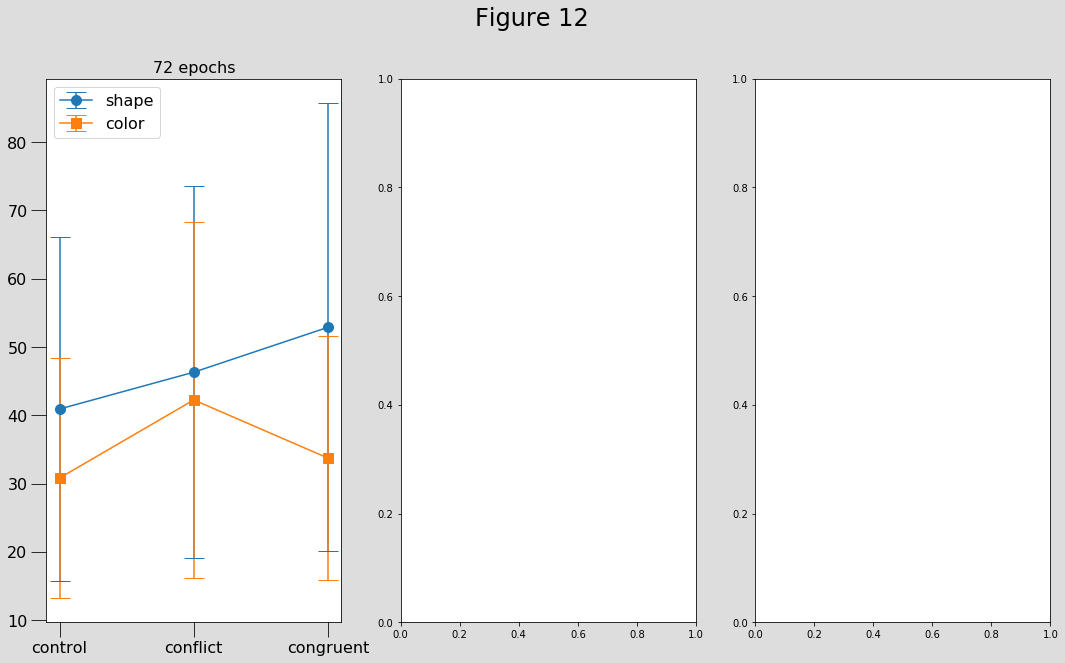

In [37]:
plot_by_condition(fixed_indirect_first_test_results)

In [24]:
for i in range(4):
    fixed_indirect_model.train()

In [25]:
fixed_indirect_five_day_test_results = fixed_indirect_model.test()

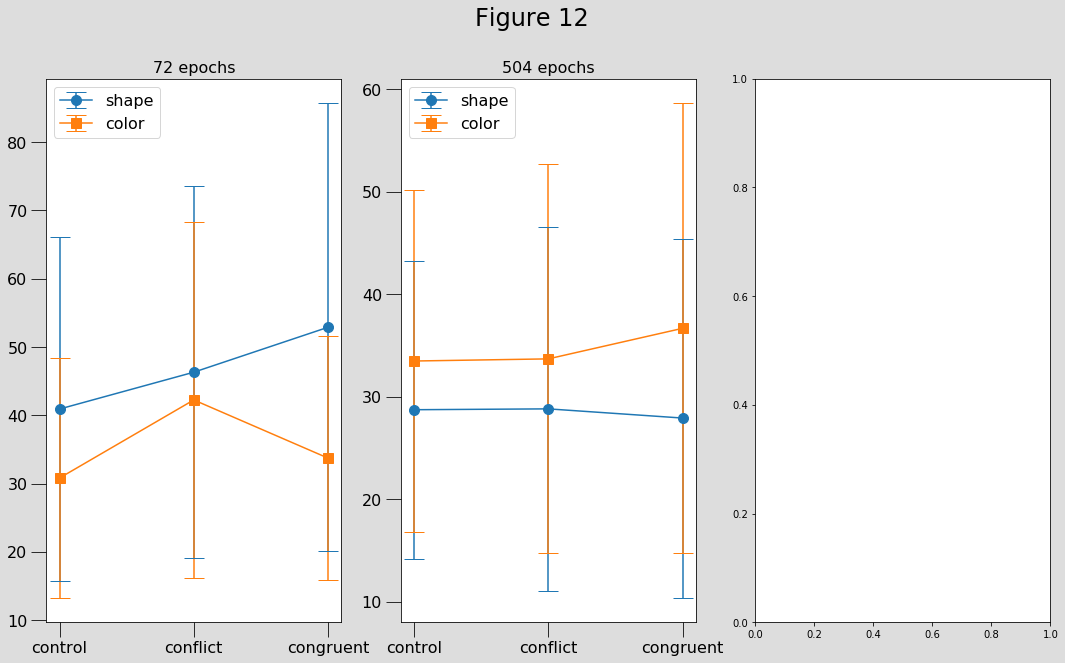

In [38]:
plot_by_condition(fixed_indirect_first_test_results, fixed_indirect_five_day_test_results)


### This is still faster, and there's something wonky going on in the congruent condition

Adding error bars to all plots above makes me think there's way too much noise. Let's reduce it (0.05 => 0.01) and try again

In [44]:
fixed_indirect_low_noise_model = shape_naming_model.ShapeNamingModel(
    2, weight_dict=fixed_indirect_weights, noise_std=0.01, indirect_learning_rate=0)

In [45]:
fixed_indirect_day_one_train = fixed_indirect_low_noise_model.train()
fixed_indirect_first_test_results = fixed_indirect_low_noise_model.test()

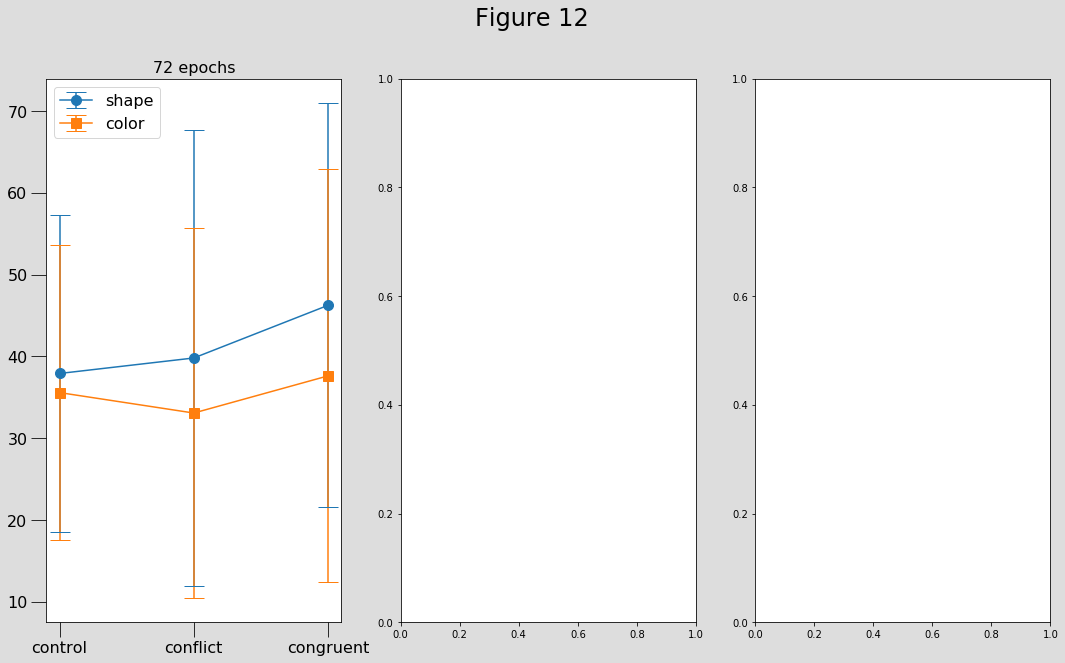

In [46]:
plot_by_condition(fixed_indirect_first_test_results)

In [47]:
for i in range(4):
    fixed_indirect_low_noise_model.train()

In [48]:
fixed_indirect_five_day_test_results = fixed_indirect_low_noise_model.test()

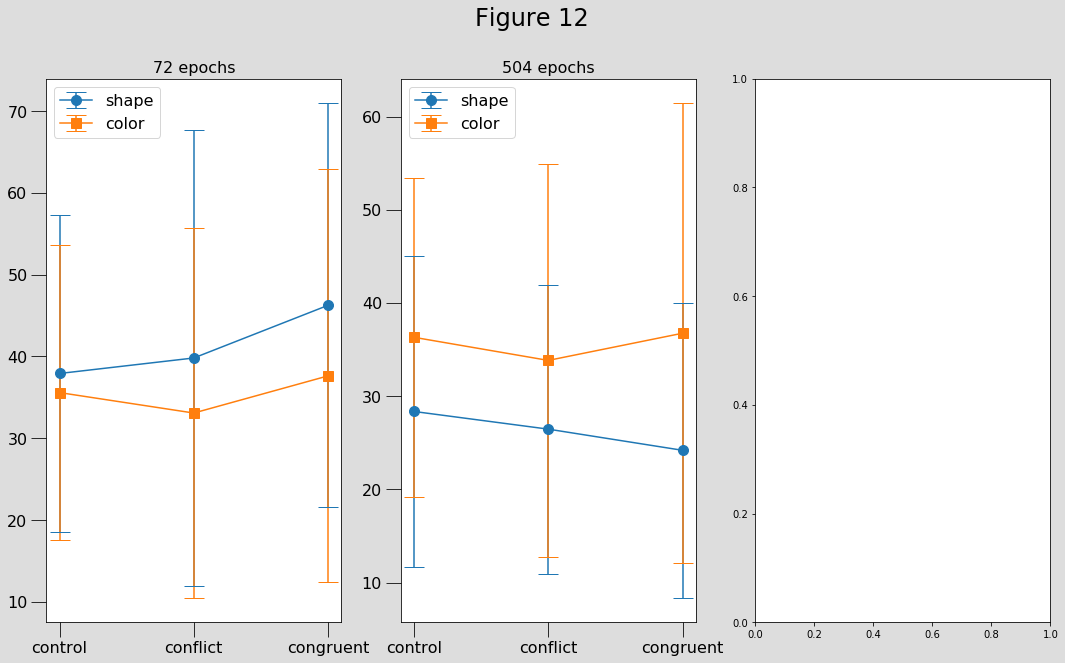

In [49]:
plot_by_condition(fixed_indirect_first_test_results, fixed_indirect_five_day_test_results)


### Let's try with a higher integration rate

In [ ]:
fixed_indirect_low_noise_high_int_model = shape_naming_model.ShapeNamingModel(
    2, weight_dict=fixed_indirect_weights, noise_std=0.01, integration_rate=0.3, indirect_learning_rate=0)

In [51]:
fixed_indirect_day_one_train = fixed_indirect_low_noise_high_int_model.train()
fixed_indirect_first_test_results = fixed_indirect_low_noise_high_int_model.test()

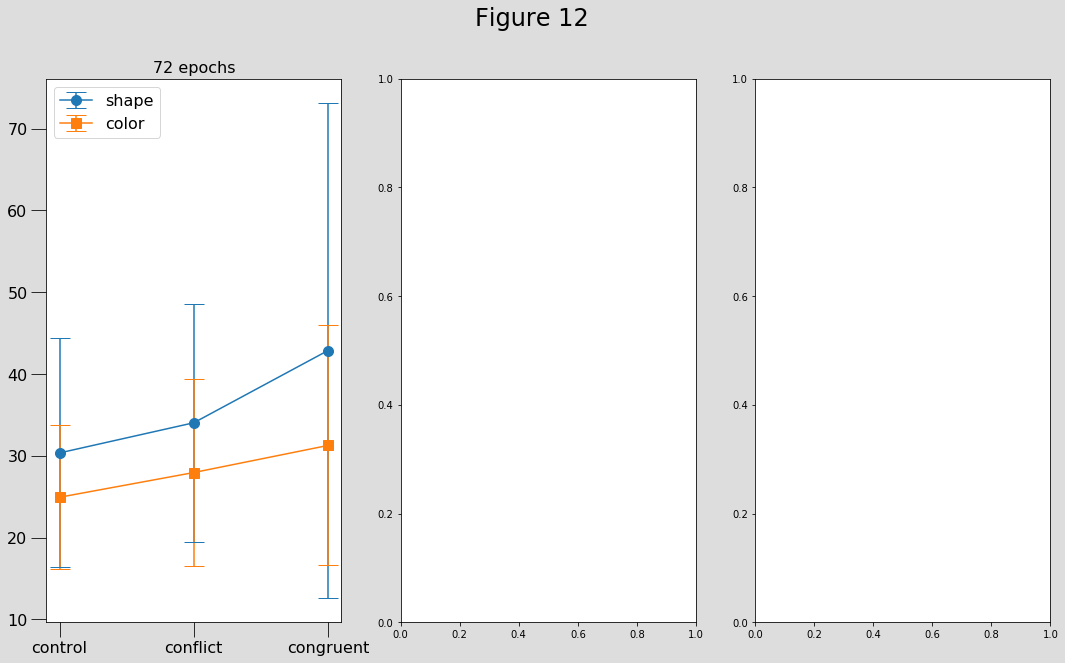

In [52]:
plot_by_condition(fixed_indirect_first_test_results)

In [53]:
for i in range(4):
    fixed_indirect_low_noise_high_int_model.train()
    
fixed_indirect_five_day_test_results = fixed_indirect_low_noise_high_int_model.test()

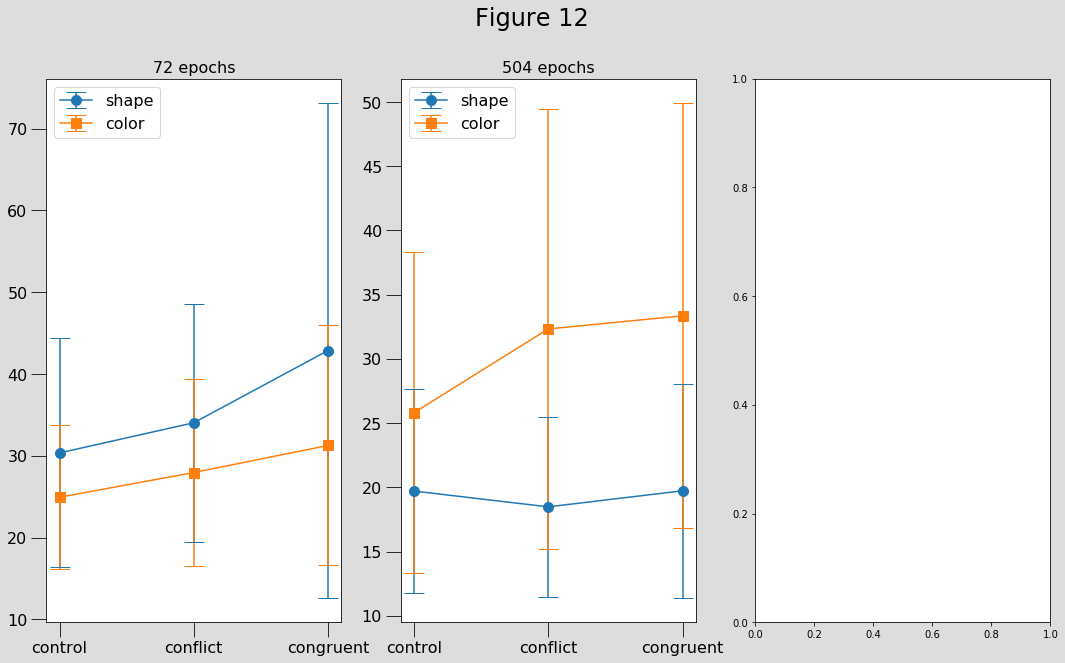

In [54]:
plot_by_condition(fixed_indirect_first_test_results, fixed_indirect_five_day_test_results)


### What about a much lower LR?

In [55]:
fixed_indirect_low_noise_high_int_low_lr_model = shape_naming_model.ShapeNamingModel(
    2, weight_dict=fixed_indirect_weights, direct_learning_rate=0.01,
    noise_std=0.01, integration_rate=0.3, indirect_learning_rate=0)

In [56]:
fixed_indirect_day_one_train = fixed_indirect_low_noise_high_int_low_lr_model.train()
fixed_indirect_first_test_results = fixed_indirect_low_noise_high_int_low_lr_model.test()

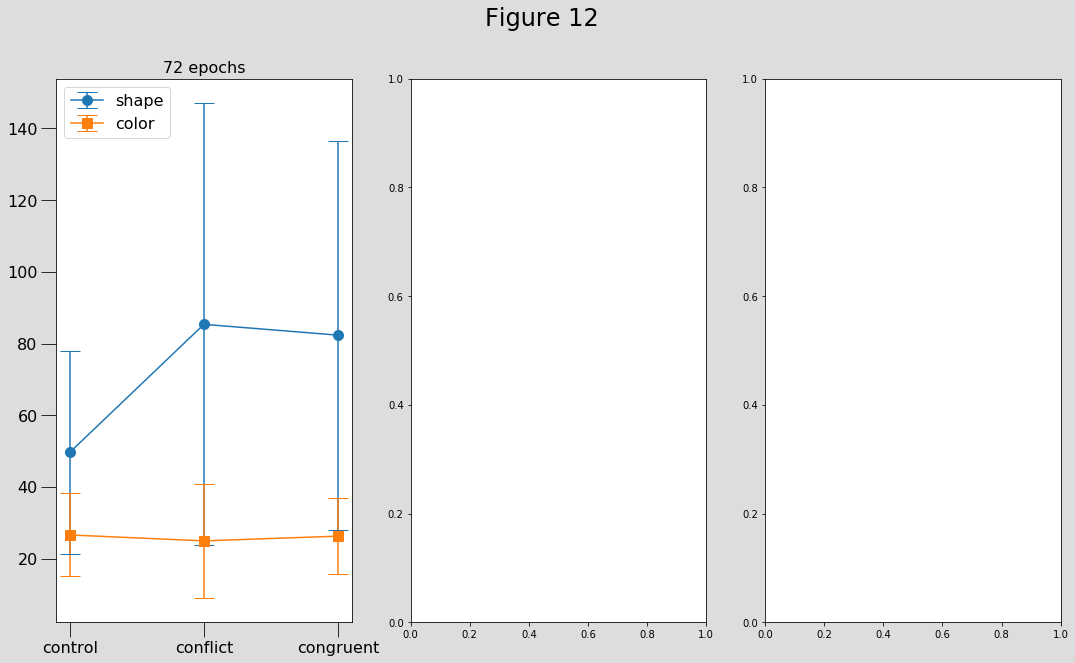

In [57]:
plot_by_condition(fixed_indirect_first_test_results)

In [58]:
for i in range(4):
    fixed_indirect_low_noise_high_int_low_lr_model.train()
    
fixed_indirect_five_day_test_results = fixed_indirect_low_noise_high_int_low_lr_model.test()

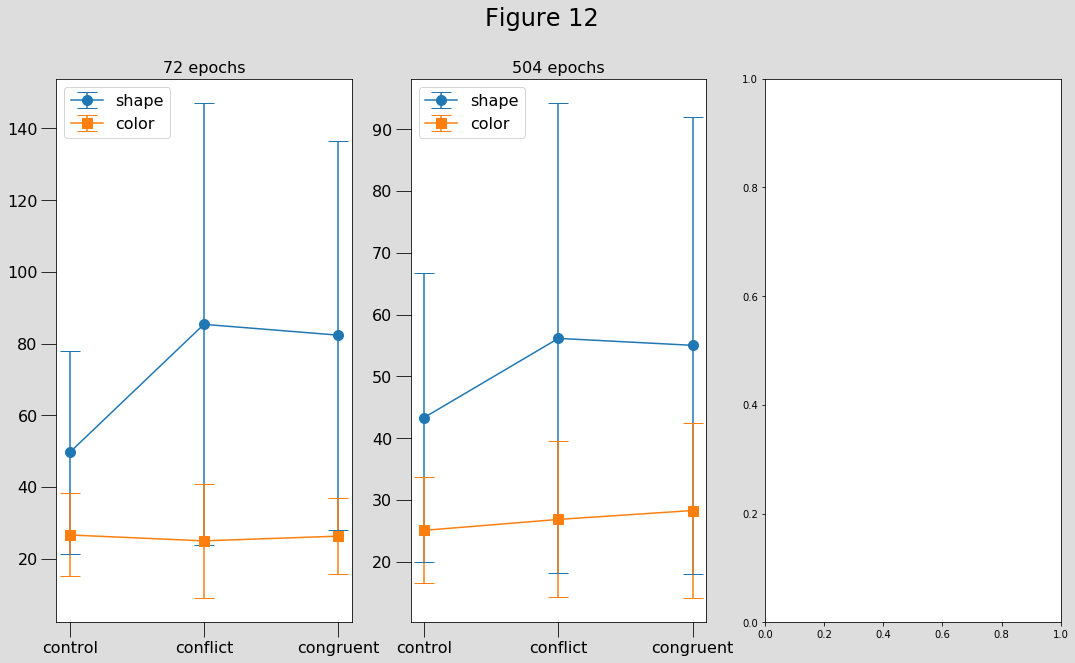

In [59]:
plot_by_condition(fixed_indirect_first_test_results, fixed_indirect_five_day_test_results)


### Pace-wise, this is the first that looks something like what I expected

Let's give it the rest of the epochs and see if the last one looks right

In [60]:
for i in range(26):
    fixed_indirect_low_noise_high_int_low_lr_model.train()
    
fixed_indirect_twenty_day_test_results = \
    fixed_indirect_low_noise_high_int_low_lr_model.test()

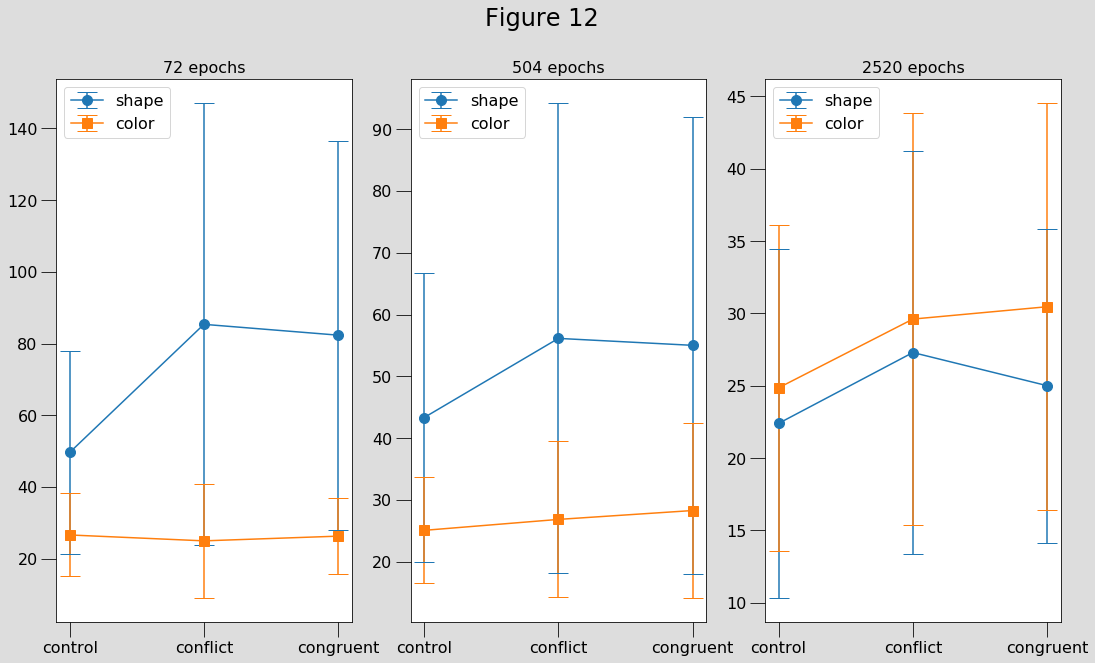

In [61]:
plot_by_condition(fixed_indirect_first_test_results, 
                  fixed_indirect_five_day_test_results,
                 fixed_indirect_twenty_day_test_results)


### Certainly better - however, the error bars are still huge

What about the integrator noise, and a slightly higher learning rate?


In [62]:
lower_accumulator_noise_model = shape_naming_model.ShapeNamingModel(
    2, weight_dict=fixed_indirect_weights, direct_learning_rate=0.02,
    noise_std=0.02, integration_rate=0.2, accumulator_noise_std=0.02, 
    indirect_learning_rate=0)

In [63]:
lower_accumulator_day_one_train = lower_accumulator_noise_model.train()
lower_accumulator_first_test_results = lower_accumulator_noise_model.test()

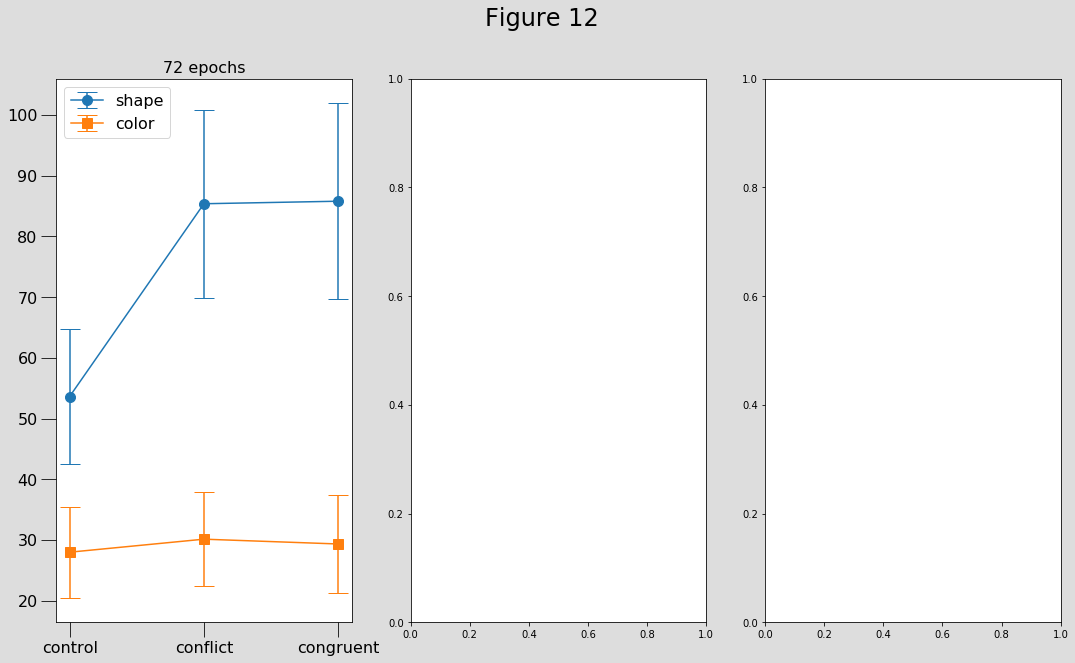

In [64]:
plot_by_condition(lower_accumulator_first_test_results)

In [65]:
for i in range(4):
    lower_accumulator_noise_model.train()
    
lower_accumulator_second_test_results = lower_accumulator_noise_model.test()

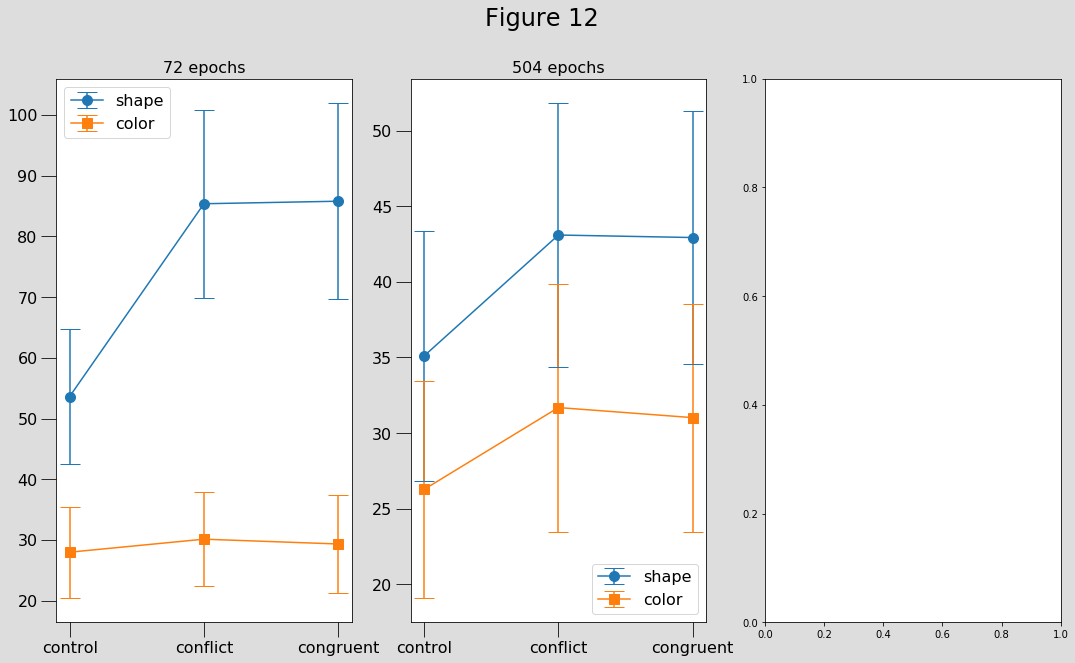

In [66]:
plot_by_condition(lower_accumulator_first_test_results, 
                  lower_accumulator_second_test_results)


In [67]:
for i in range(26):
    lower_accumulator_noise_model.train()
    
lower_accumulator_third_test_results = \
    lower_accumulator_noise_model.test()

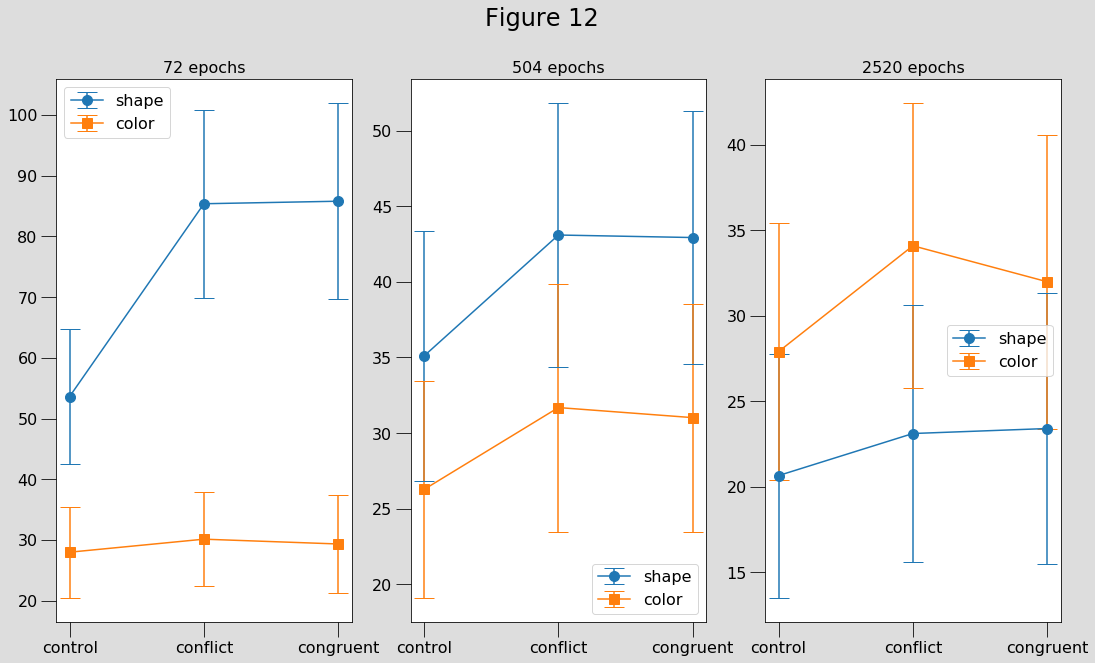

In [68]:
plot_by_condition(lower_accumulator_first_test_results, 
                  lower_accumulator_second_test_results,
                 lower_accumulator_third_test_results)


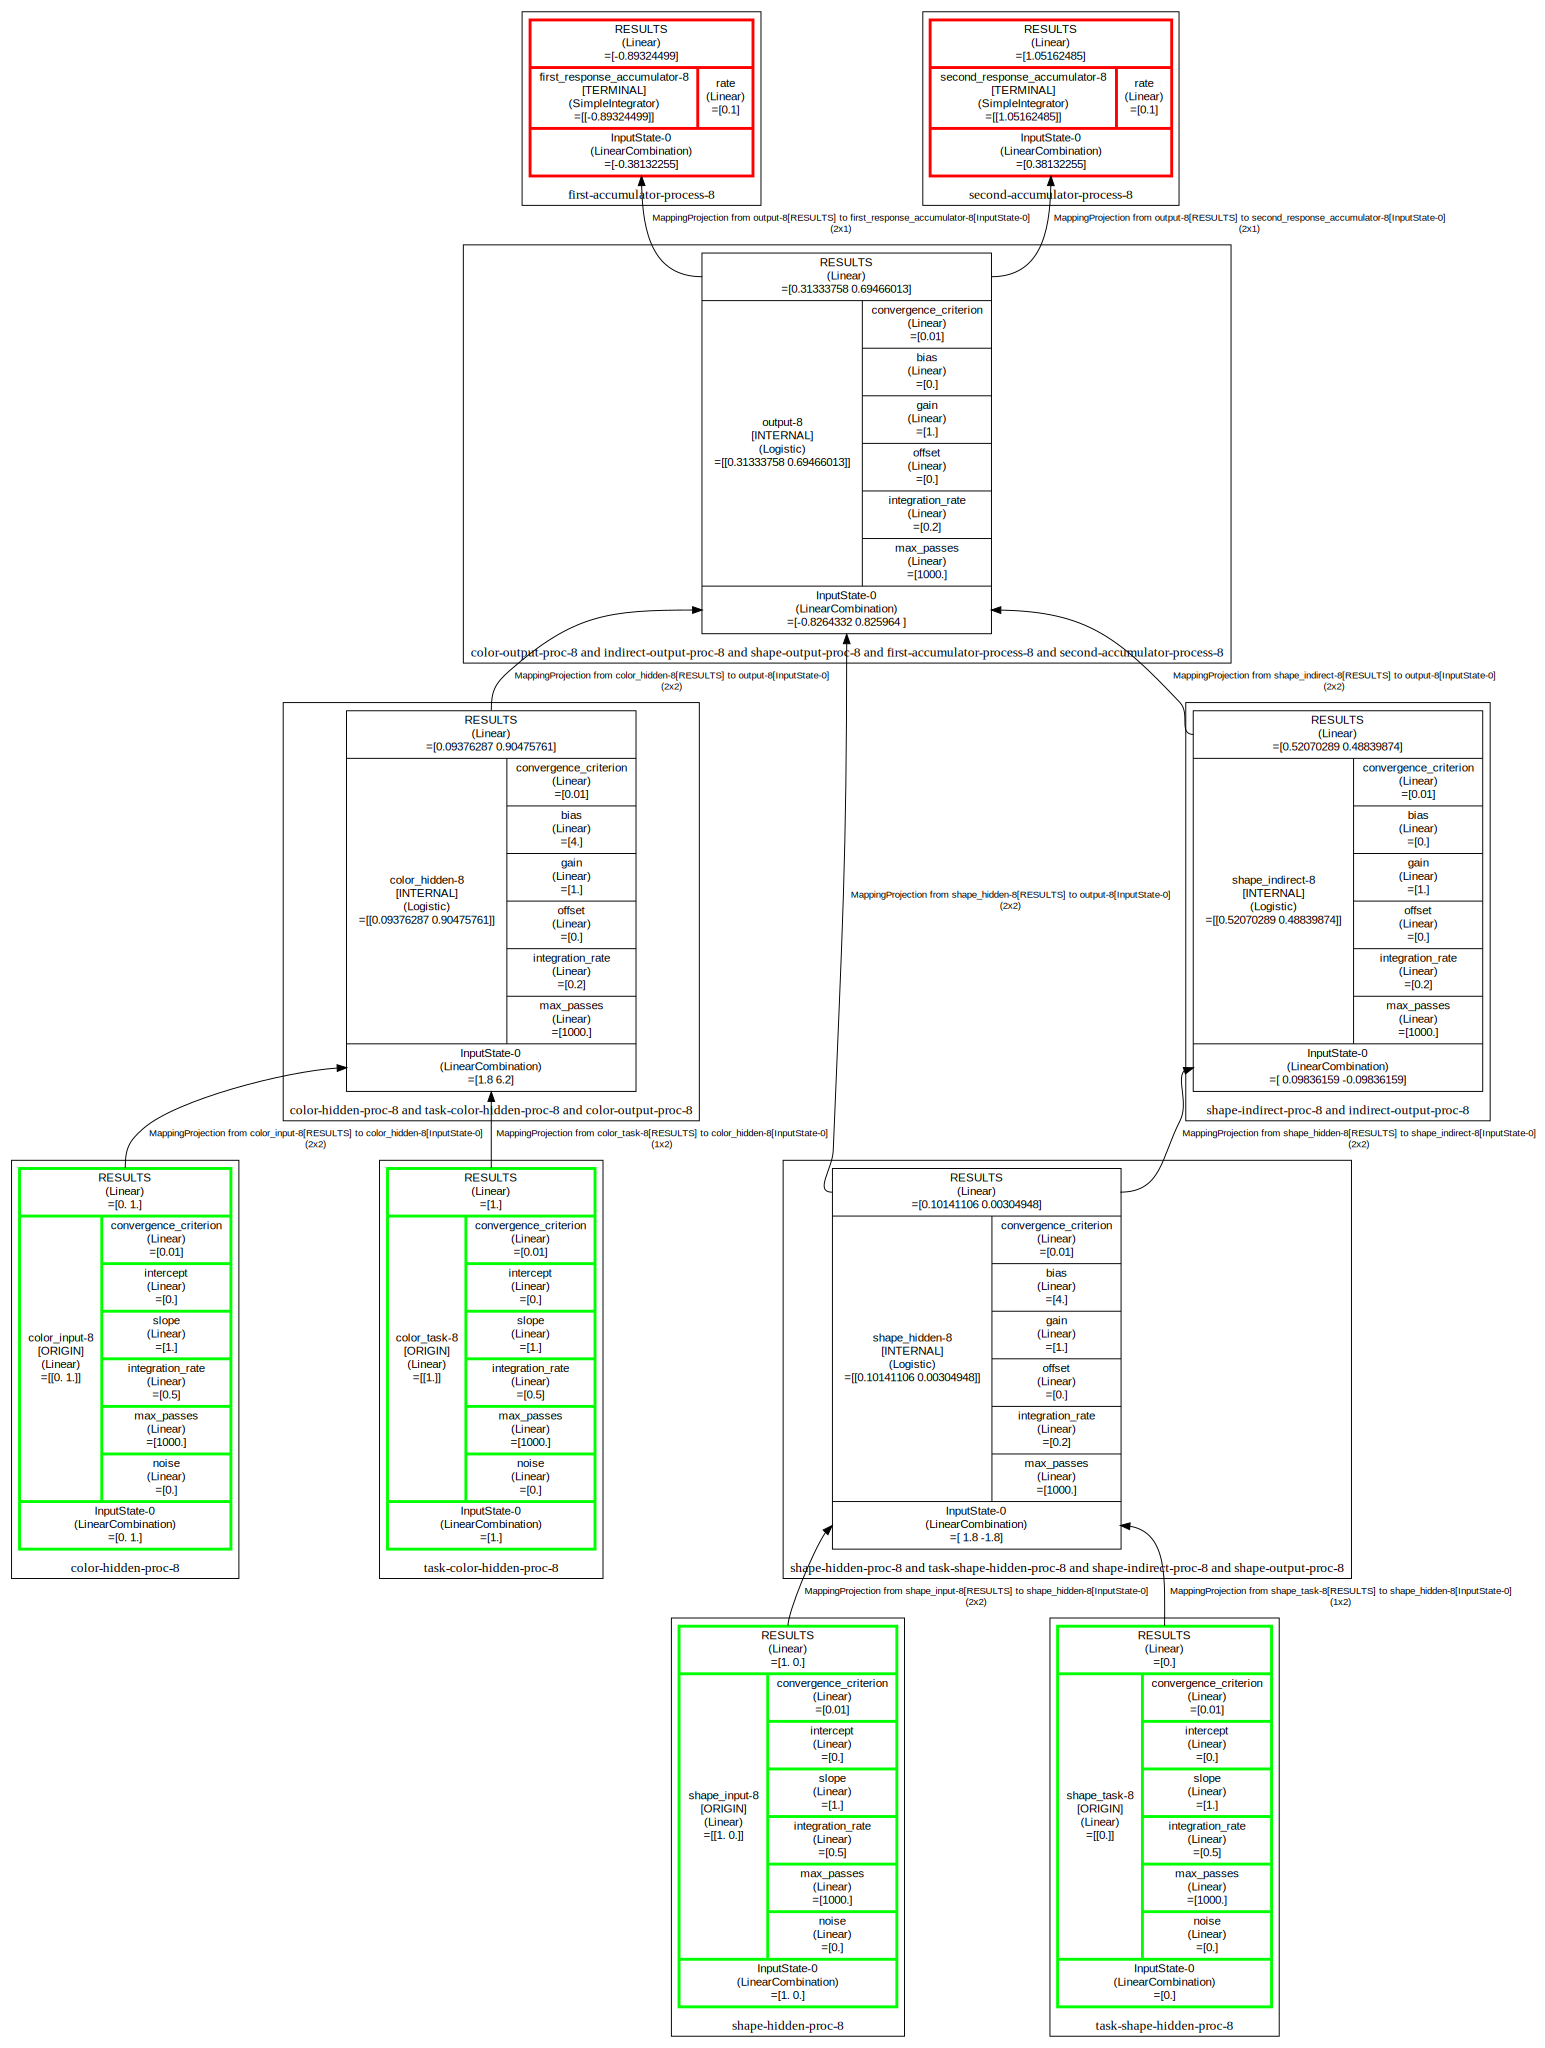

In [97]:
lower_accumulator_noise_model.system.show_graph(show_dimensions=pnl.ALL, show_projection_labels=pnl.ALL, show_processes=pnl.ALL, show_mechanism_structure=pnl.ALL, output_fmt='jupyter')

## Let's run a similar condition, but allowing the indirect pathway to learn rather than fixing it

In [70]:
lower_accumulator_noise_indirect_learning_model = shape_naming_model.ShapeNamingModel(
    2, direct_learning_rate=0.02, noise_std=0.02, 
    integration_rate=0.2, accumulator_noise_std=0.02, 
    indirect_learning_rate=0.1)

In [71]:
lower_accumulator_noise_indirect_learning_day_one_results = day_one(lower_accumulator_noise_indirect_learning_model)

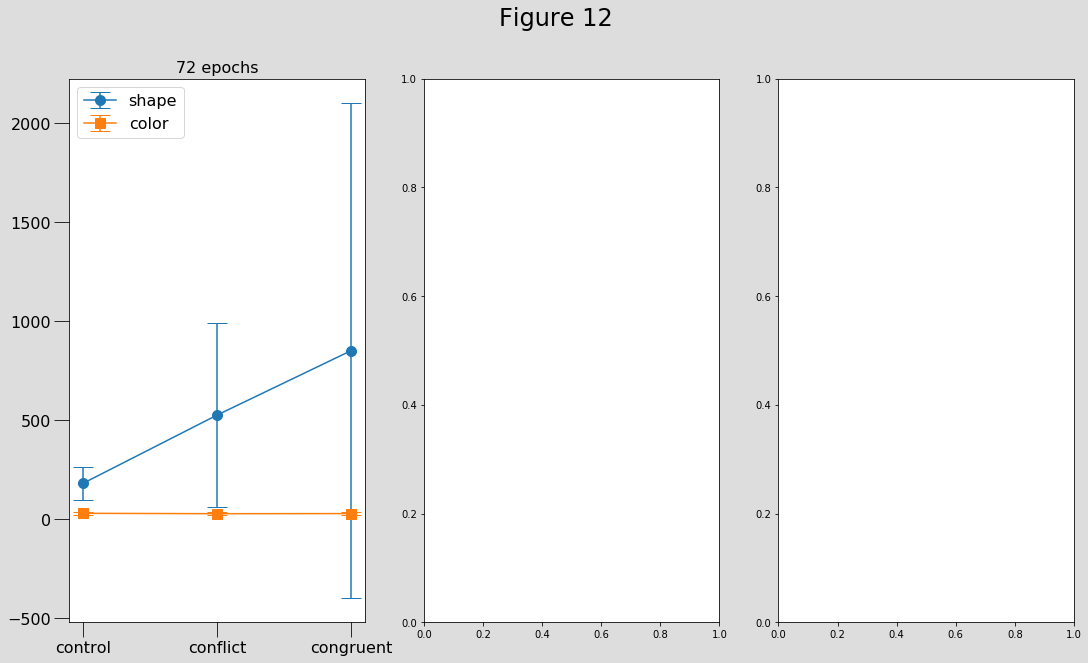

In [72]:
plot_by_condition(lower_accumulator_noise_indirect_learning_day_one_results)

In [73]:
lower_accumulator_noise_indirect_learning_day_five_results = day_five(lower_accumulator_noise_indirect_learning_model)

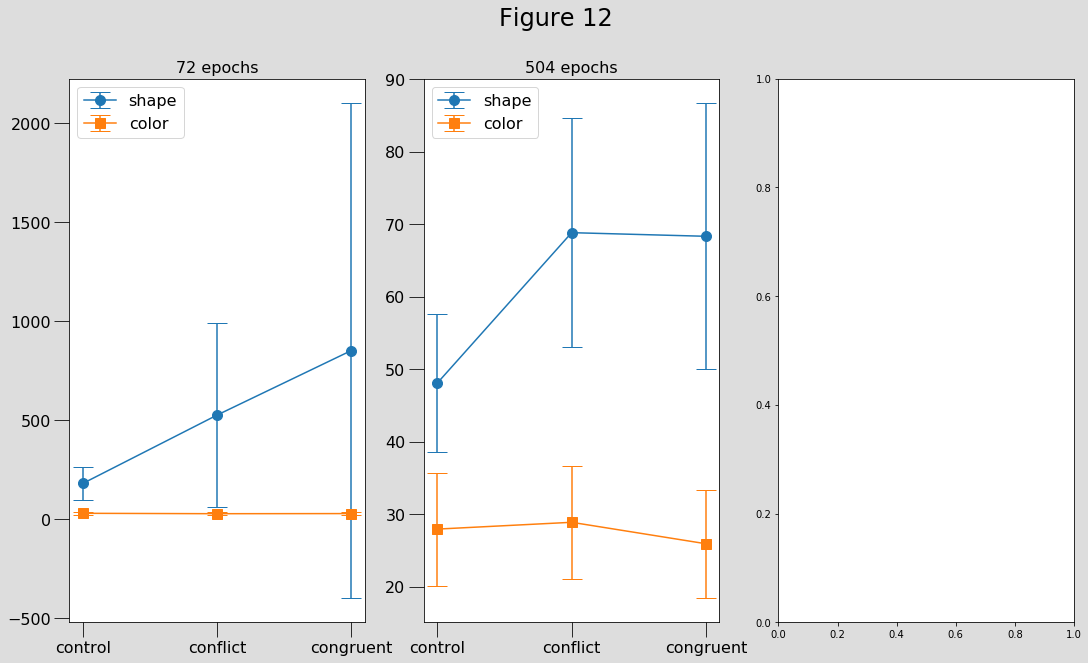

In [74]:
plot_by_condition(lower_accumulator_noise_indirect_learning_day_one_results,
                 lower_accumulator_noise_indirect_learning_day_five_results)

In [75]:
lower_accumulator_noise_indirect_learning_day_twenty_results = day_twenty(lower_accumulator_noise_indirect_learning_model)

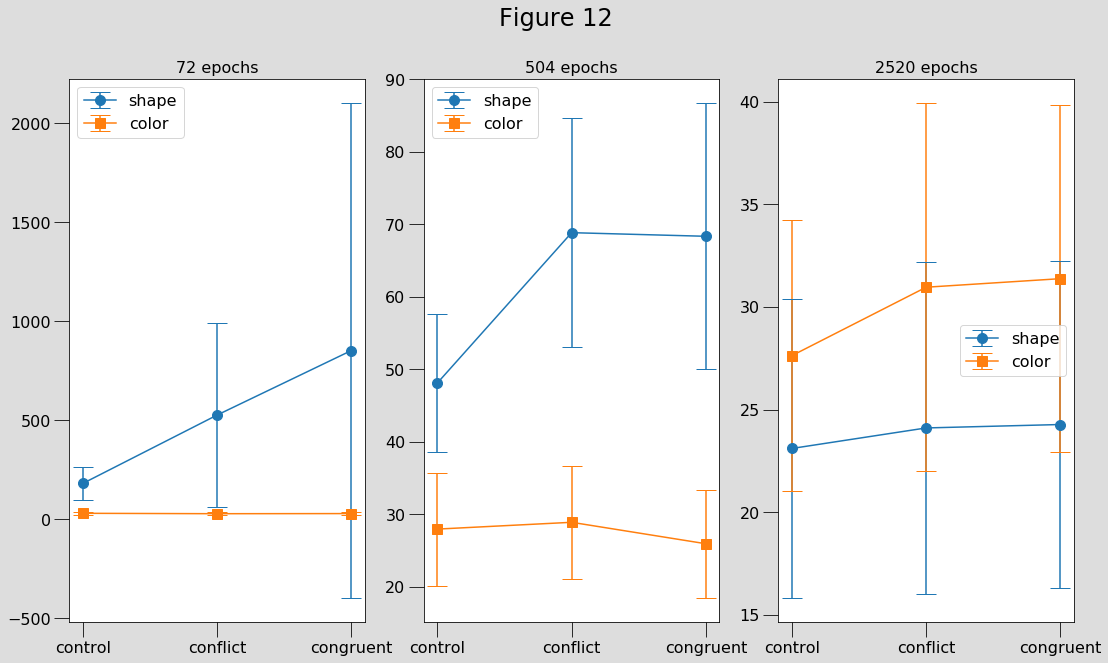

In [76]:
plot_by_condition(lower_accumulator_noise_indirect_learning_day_one_results,
                 lower_accumulator_noise_indirect_learning_day_five_results,
                 lower_accumulator_noise_indirect_learning_day_twenty_results)

## Once more with gusto

Trying with a slightly higher learning rate and slightly less accumulation noise

In [77]:
lower_noise_faster_indirect_learning_model = shape_naming_model.ShapeNamingModel(
    2, direct_learning_rate=0.02, noise_std=0.01, 
    integration_rate=0.2, accumulator_noise_std=0.01, 
    indirect_learning_rate=0.2)

In [79]:
lower_noise_faster_indirect_learning_day_one_results = day_one(lower_noise_faster_indirect_learning_model)

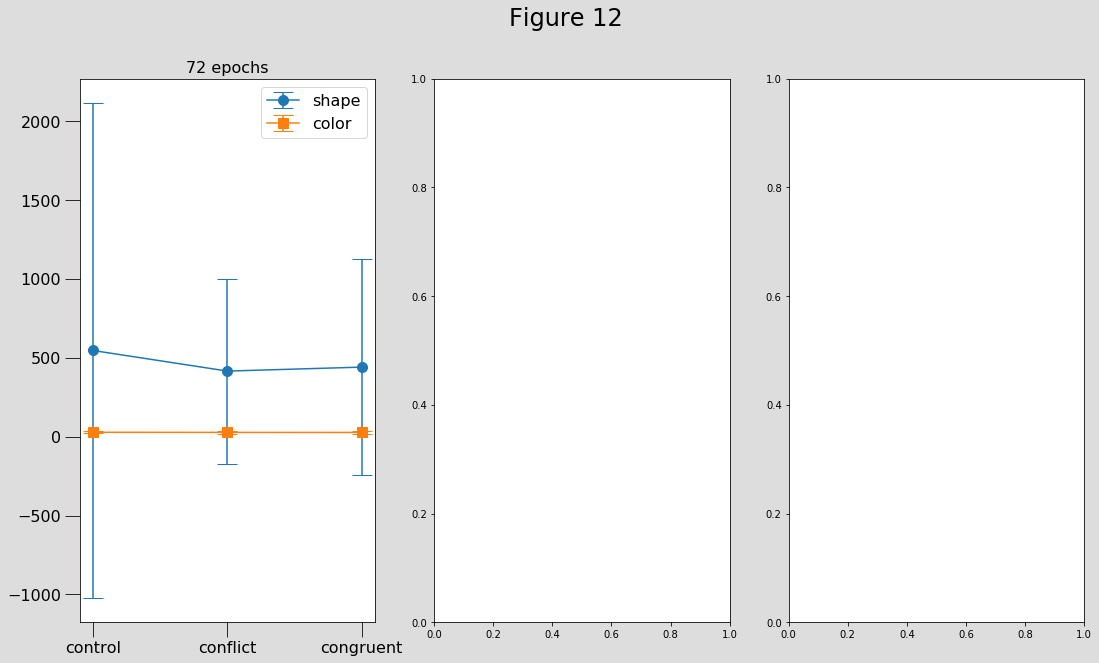

In [80]:
plot_by_condition(lower_noise_faster_indirect_learning_day_one_results)

In [81]:
lower_noise_faster_indirect_learning_day_five_results = day_five(lower_noise_faster_indirect_learning_model)

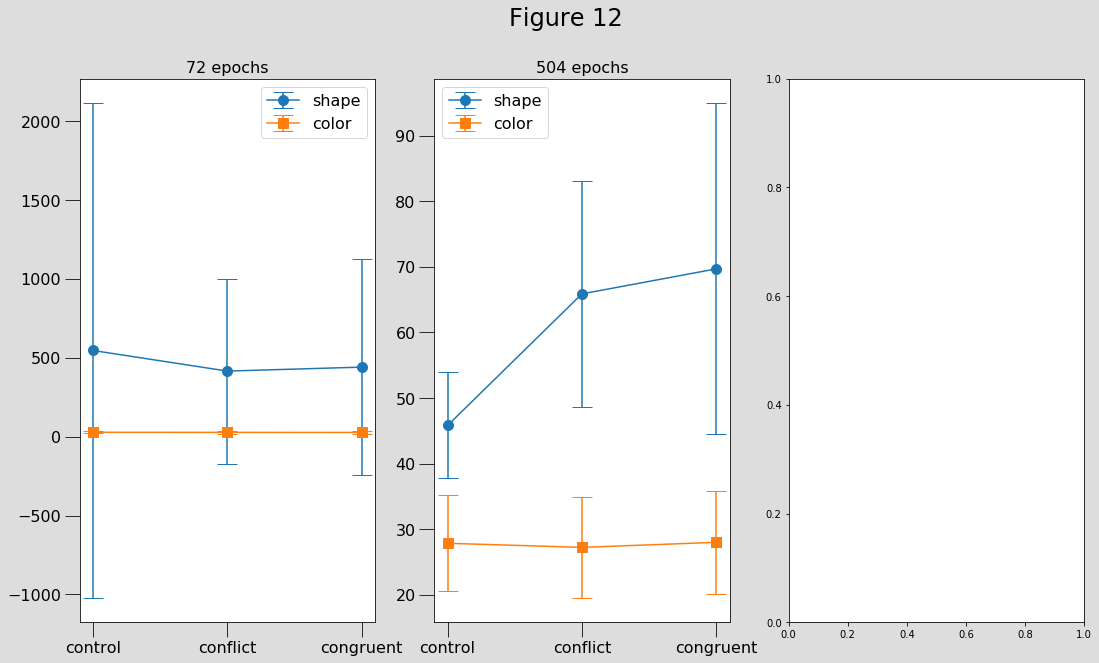

In [85]:
plot_by_condition(lower_noise_faster_indirect_learning_day_one_results,
                 lower_noise_faster_indirect_learning_day_five_results)

In [86]:
lower_noise_faster_indirect_learning_day_twenty_results = day_twenty(lower_noise_faster_indirect_learning_model)

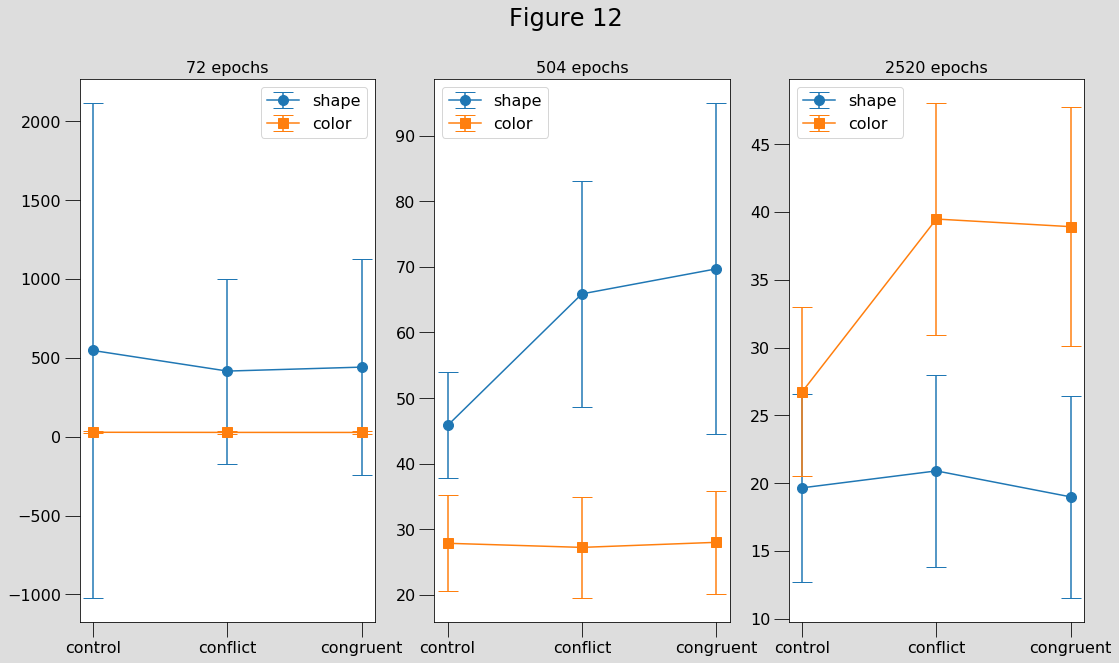

In [87]:
plot_by_condition(lower_noise_faster_indirect_learning_day_one_results,
                 lower_noise_faster_indirect_learning_day_five_results,
                 lower_noise_faster_indirect_learning_day_twenty_results)

In [92]:
lower_noise_faster_indirect_learning_model.indirect_output_process.pathway[1].function_params


{'matrix': (array([[-0.00344124,  0.00557042],
       [-0.01737403,  0.01344761]]), 'LEARNING')}

In [93]:
lower_noise_faster_indirect_learning_model.shape_indirect_process.pathway[1].function_params

{'matrix': (array([[-0.0160119 , -0.00502867],
       [ 0.01732707,  0.0084649 ]]), 'LEARNING')}

In [94]:
lower_noise_faster_indirect_learning_model.shape_hidden_process.pathway[1].function_params

{'matrix': array([[ 1.8, -1.8],
       [-1.8,  1.8]])}

## Added some functionality to the model to allow accessing the logged data more easily

In [14]:
lower_accumulator_noise_model = shape_naming_model.ShapeNamingModel(
    2, weight_dict=fixed_indirect_weights, direct_learning_rate=0.02,
    noise_std=0.01, integration_rate=0.2, accumulator_noise_std=0.01, 
    indirect_learning_rate=0)

In [15]:
_ = lower_accumulator_noise_model.train()
train_df = lower_accumulator_noise_model.last_run_to_dataframe()

In [16]:
lower_accumulator_noise_model.test(trials_per_stimulus_per_test_block=2, conflict_condition=False, control_condition=False, randomize_phase_order=False)

(defaultdict(list, {'congruent': [30, 34, 56, 35]}),
 defaultdict(list, {'congruent': [27, 36, 35, 33]}),
 False)

In [17]:
color_naming_df = lower_accumulator_noise_model.last_color_naming_df
shape_naming_df = lower_accumulator_noise_model.last_shape_naming_df

In [18]:
color_naming_df[color_naming_df['Pass'] == 0]

,Run,Trial,Pass,Time_step,color_hidden-2_0,color_hidden-2_1,shape_hidden-2_0,shape_hidden-2_1,shape_indirect-1_0,shape_indirect-1_1,output-2_0,output-2_1,first_response_accumulator-2_0,second_response_accumulator-2_0
0,1.0,0.0,0.0,1.0,0.500000,0.500000,0.017986,0.017986,0.500000,0.500000,0.500059,0.499850,-0.005029,0.010580
1,1.0,1.0,0.0,1.0,0.058612,0.025374,0.025641,0.012503,0.498770,0.499138,0.502790,0.503542,0.002930,0.020952
29,1.0,2.0,0.0,1.0,0.500000,0.500000,0.017986,0.017986,0.500000,0.500000,0.500059,0.499850,0.009556,-0.007697
30,1.0,3.0,0.0,1.0,0.786552,0.212131,0.051957,0.006055,0.517166,0.488042,0.741745,0.262173,0.045083,-0.052364
67,1.0,4.0,0.0,1.0,0.500000,0.500000,0.017986,0.017986,0.500000,0.500000,0.500059,0.499850,0.002246,0.002871
68,1.0,5.0,0.0,1.0,0.210142,0.794069,0.006362,0.050659,0.481482,0.522324,0.257540,0.738276,-0.044360,0.047060
104,1.0,6.0,0.0,1.0,0.500000,0.500000,0.017986,0.017986,0.500000,0.500000,0.500059,0.499850,0.015346,0.001709
105,1.0,7.0,0.0,1.0,0.791396,0.219486,0.050761,0.006310,0.527842,0.479360,0.741714,0.258750,0.043211,-0.053156


In [19]:
shape_naming_df[shape_naming_df['Pass'] == 0]

,Run,Trial,Pass,Time_step,color_hidden-2_0,color_hidden-2_1,shape_hidden-2_0,shape_hidden-2_1,shape_indirect-1_0,shape_indirect-1_1,output-2_0,output-2_1,first_response_accumulator-2_0,second_response_accumulator-2_0
0,2.0,0.0,0.0,1.0,0.017986,0.017986,0.500000,0.500000,0.500000,0.500000,0.501637,0.495828,0.005271,-0.002727
1,2.0,1.0,0.0,1.0,0.048695,0.801453,0.006651,0.196949,0.469857,0.539008,0.248672,0.745161,-0.051427,0.049249
32,2.0,2.0,0.0,1.0,0.017986,0.017986,0.500000,0.500000,0.500000,0.500000,0.501436,0.496036,0.003845,-0.006047
33,2.0,3.0,0.0,1.0,0.002009,0.144775,0.135761,0.854887,0.330656,0.677140,0.356139,0.642956,-0.035586,0.034874
68,2.0,4.0,0.0,1.0,0.017986,0.017986,0.500000,0.500000,0.500000,0.500000,0.501231,0.496243,0.012157,0.004229
69,2.0,5.0,0.0,1.0,0.004947,0.063731,0.250515,0.746041,0.331405,0.660571,0.364592,0.631150,-0.021421,0.029685
126,2.0,6.0,0.0,1.0,0.017986,0.017986,0.500000,0.500000,0.500000,0.500000,0.501430,0.496045,-0.016894,0.006806
127,2.0,7.0,0.0,1.0,0.144335,0.002043,0.859810,0.143113,0.676465,0.324539,0.646019,0.347842,0.038292,-0.030134


In [20]:
color_naming_df[color_naming_df['Trial'] == 1]

,Run,Trial,Pass,Time_step,color_hidden-2_0,color_hidden-2_1,shape_hidden-2_0,shape_hidden-2_1,shape_indirect-1_0,shape_indirect-1_1,output-2_0,output-2_1,first_response_accumulator-2_0,second_response_accumulator-2_0
1,1.0,1.0,0.0,1.0,0.058612,0.025374,0.025641,0.012503,0.498770,0.499138,0.502790,0.503542,0.002930,0.020952
2,1.0,1.0,1.0,1.0,0.144523,0.033351,0.033445,0.009428,0.495518,0.499035,0.504988,0.491197,0.008439,-0.001163
3,1.0,1.0,2.0,1.0,0.273119,0.042168,0.042142,0.007488,0.495663,0.493786,0.522386,0.478668,0.003933,0.001656
4,1.0,1.0,3.0,1.0,0.414989,0.049419,0.050557,0.006318,0.501892,0.492893,0.541964,0.460272,0.001914,-0.008677
5,1.0,1.0,4.0,1.0,0.537083,0.056763,0.058073,0.005450,0.504747,0.489967,0.561792,0.436099,0.033380,-0.015105
6,1.0,1.0,5.0,1.0,0.634411,0.063014,0.065195,0.004818,0.502773,0.486148,0.587017,0.408312,0.058559,-0.042087
7,1.0,1.0,6.0,1.0,0.706090,0.068462,0.071252,0.004294,0.507670,0.485451,0.613383,0.387938,0.086423,-0.075288
8,1.0,1.0,7.0,1.0,0.757904,0.075118,0.077228,0.003917,0.508044,0.479294,0.637172,0.365369,0.120678,-0.109990
9,1.0,1.0,8.0,1.0,0.793851,0.079603,0.080669,0.003723,0.513981,0.474600,0.655611,0.344507,0.145629,-0.136413
10,1.0,1.0,9.0,1.0,0.821264,0.082643,0.085038,0.003562,0.516056,0.475706,0.674777,0.325199,0.187511,-0.178920


In [21]:
 [shape_naming_df['Trial'] == 1]

,Run,Trial,Pass,Time_step,color_hidden-2_0,color_hidden-2_1,shape_hidden-2_0,shape_hidden-2_1,shape_indirect-1_0,shape_indirect-1_1,output-2_0,output-2_1,first_response_accumulator-2_0,second_response_accumulator-2_0
1,2.0,1.0,0.0,1.0,0.048695,0.801453,0.006651,0.196949,0.469857,0.539008,0.248672,0.745161,-0.051427,0.049249
2,2.0,1.0,1.0,1.0,0.026108,0.680453,0.012532,0.315317,0.458879,0.548096,0.255061,0.738728,-0.088873,0.086575
3,2.0,1.0,2.0,1.0,0.015791,0.560956,0.020804,0.437097,0.441010,0.560375,0.262122,0.732032,-0.130588,0.124125
4,2.0,1.0,3.0,1.0,0.010512,0.460456,0.030905,0.540010,0.430567,0.573107,0.272036,0.720611,-0.173094,0.155644
5,2.0,1.0,4.0,1.0,0.007571,0.380638,0.042610,0.616213,0.414873,0.581748,0.285925,0.709868,-0.217702,0.213924
6,2.0,1.0,5.0,1.0,0.005718,0.321435,0.054823,0.678656,0.404950,0.597024,0.294206,0.692731,-0.258125,0.258747
7,2.0,1.0,6.0,1.0,0.004651,0.279471,0.066751,0.720685,0.391263,0.606322,0.303816,0.687198,-0.288447,0.299684
8,2.0,1.0,7.0,1.0,0.003901,0.248361,0.077721,0.751847,0.377599,0.620292,0.313078,0.681824,-0.329425,0.347075
9,2.0,1.0,8.0,1.0,0.003425,0.224532,0.087999,0.776954,0.367390,0.630426,0.318809,0.678438,-0.364439,0.374726
10,2.0,1.0,9.0,1.0,0.003052,0.204065,0.096852,0.796516,0.357280,0.638818,0.324998,0.673118,-0.392519,0.412909


## I have a hunch that the indirect pathway contributes to the lack of a congurency effect

This is because its outputs end up being fairly equal, and they feed evenly with the two hidden layers to the output. What if I remove it?

In [6]:
no_indirect_model = shape_naming_model.ShapeNamingModel(
    2, indirect_path=False, weight_dict=fixed_indirect_weights, direct_learning_rate=0.1,
    noise_std=0.01, integration_rate=0.2, accumulator_noise_std=0.01, 
    indirect_learning_rate=0)

In [7]:
no_indirect_day_one_results = day_one(no_indirect_model)

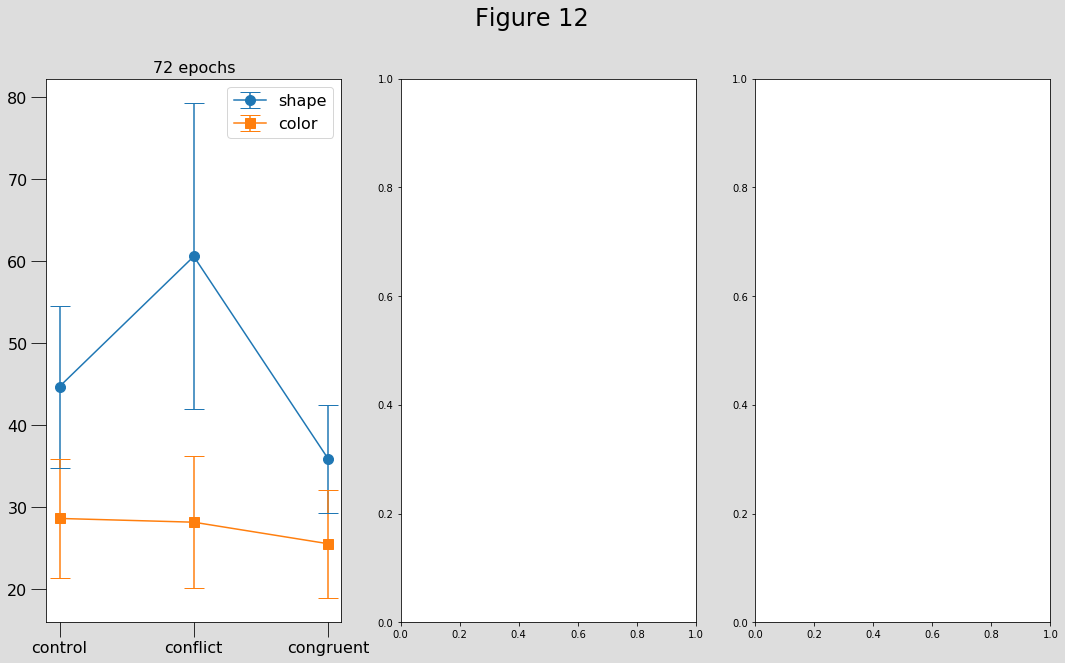

In [8]:
plot_by_condition(no_indirect_day_one_results)

In [9]:
no_indirect_day_five_results = day_five(no_indirect_model)

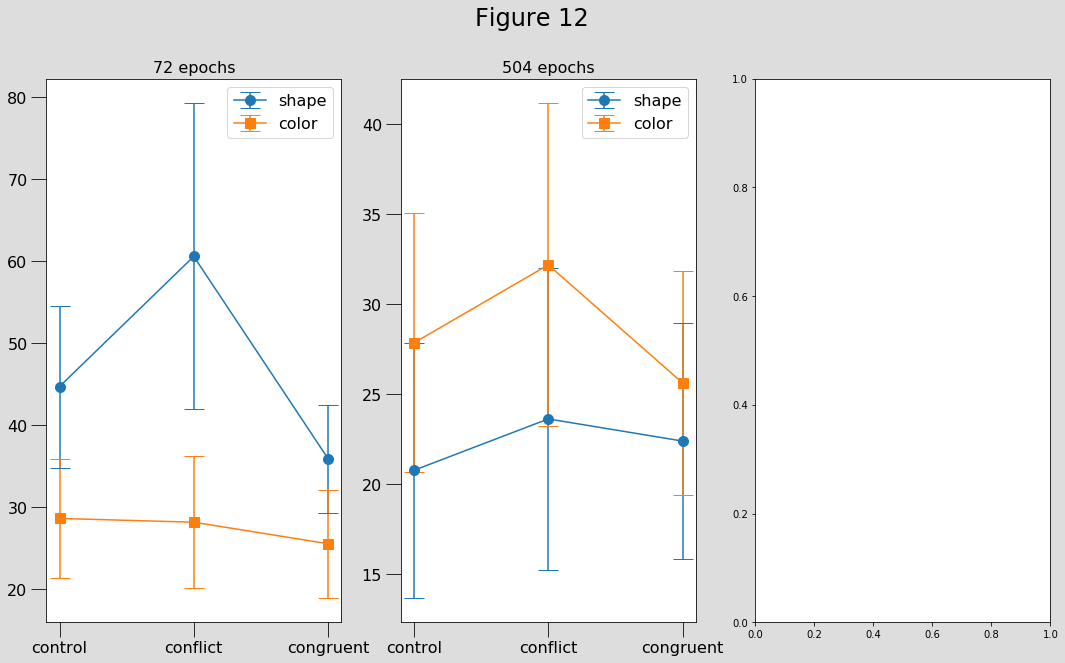

In [10]:
plot_by_condition(no_indirect_day_one_results,
                 no_indirect_day_five_results)

In [11]:
no_indirect_day_twenty_results = day_twenty(no_indirect_model)

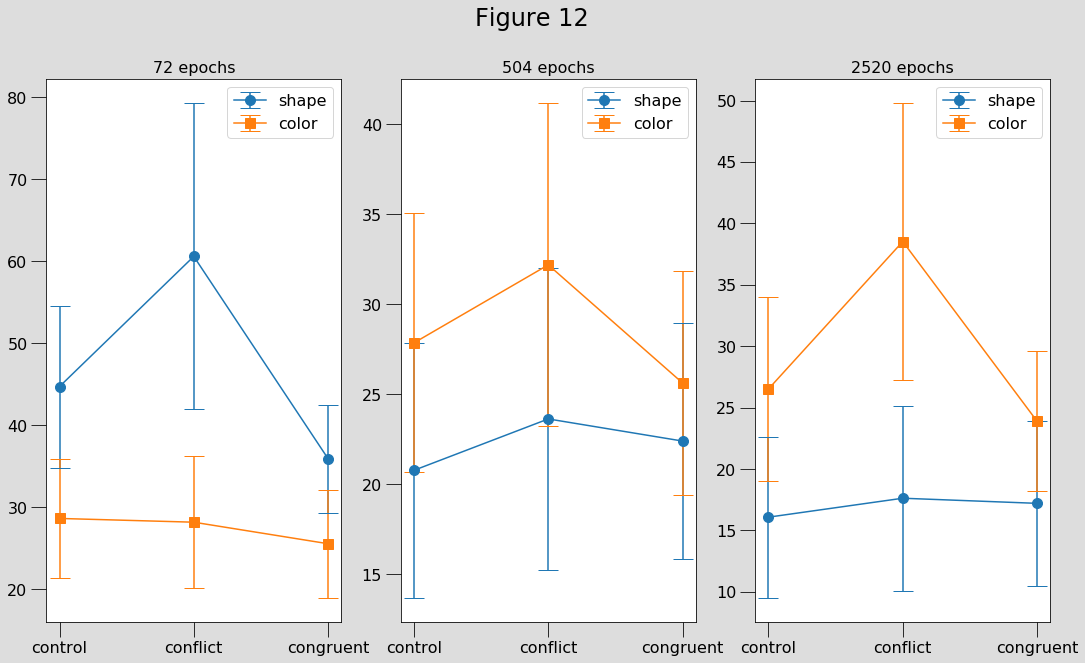

In [12]:
plot_by_condition(no_indirect_day_one_results,
                 no_indirect_day_five_results,
                 no_indirect_day_twenty_results)

## Trying a version with different indirect weights and biases

In [22]:
adj_fixed_indirect_weights = shape_naming_model.DEFAULT_WEIGHT_DICT.copy()
adj_fixed_indirect_weights[shape_naming_model.SHAPE_INDIRECT_KEY] = \
    np.matrix([[4, -4], [-4, 4]])

adj_fixed_indirect_weights[shape_naming_model.INDIRECT_OUTPUT_KEY] = \
    np.matrix([[1, -1], [-1, 1]])

In [23]:
adj_indirect_lower_accumulator_noise_model = shape_naming_model.ShapeNamingModel(
    2, weight_dict=adj_fixed_indirect_weights, direct_learning_rate=0.02,
    noise_std=0.01, integration_rate=0.2, accumulator_noise_std=0.01, 
    indirect_learning_rate=0, indirect_bias=2)

In [27]:
adj_indirect_day_one_results = day_one(adj_indirect_lower_accumulator_noise_model)

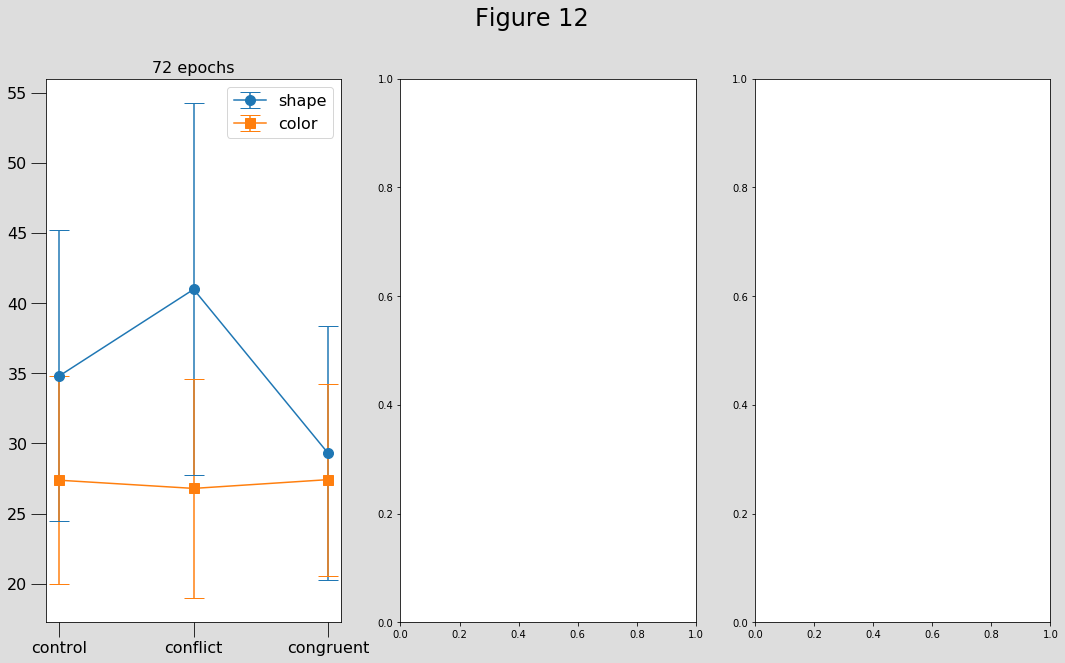

In [28]:
plot_by_condition(adj_indirect_day_one_results)

In [29]:
adj_indirect_day_five_results = day_five(adj_indirect_lower_accumulator_noise_model)

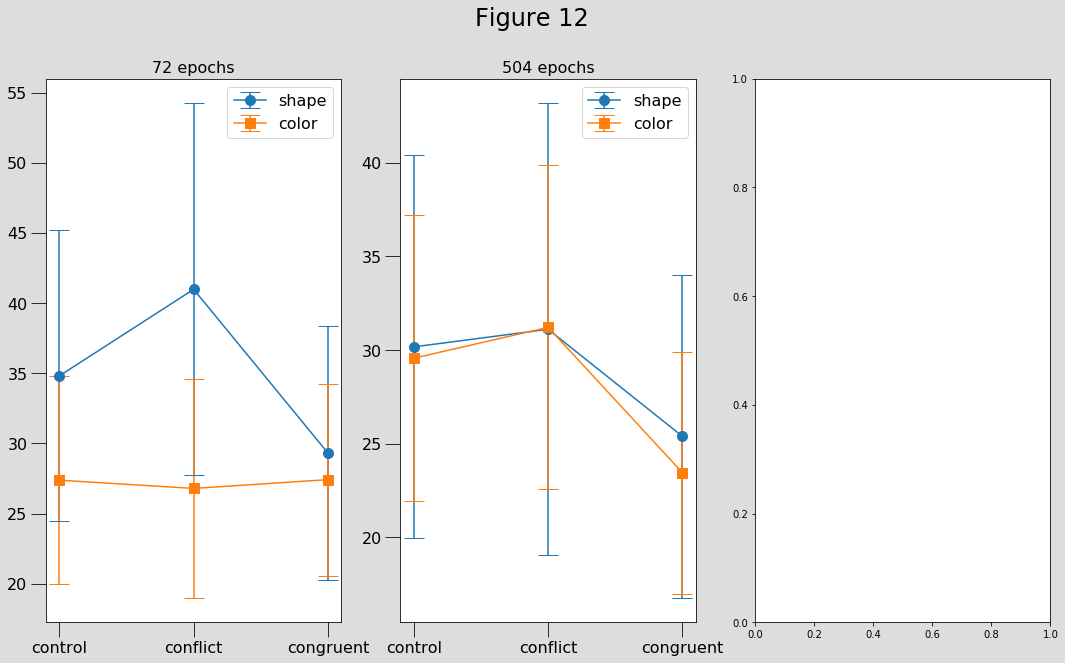

In [30]:
plot_by_condition(adj_indirect_day_one_results,
                 adj_indirect_day_five_results)

In [31]:
adj_indirect_day_twenty_results = day_twenty(adj_indirect_lower_accumulator_noise_model)

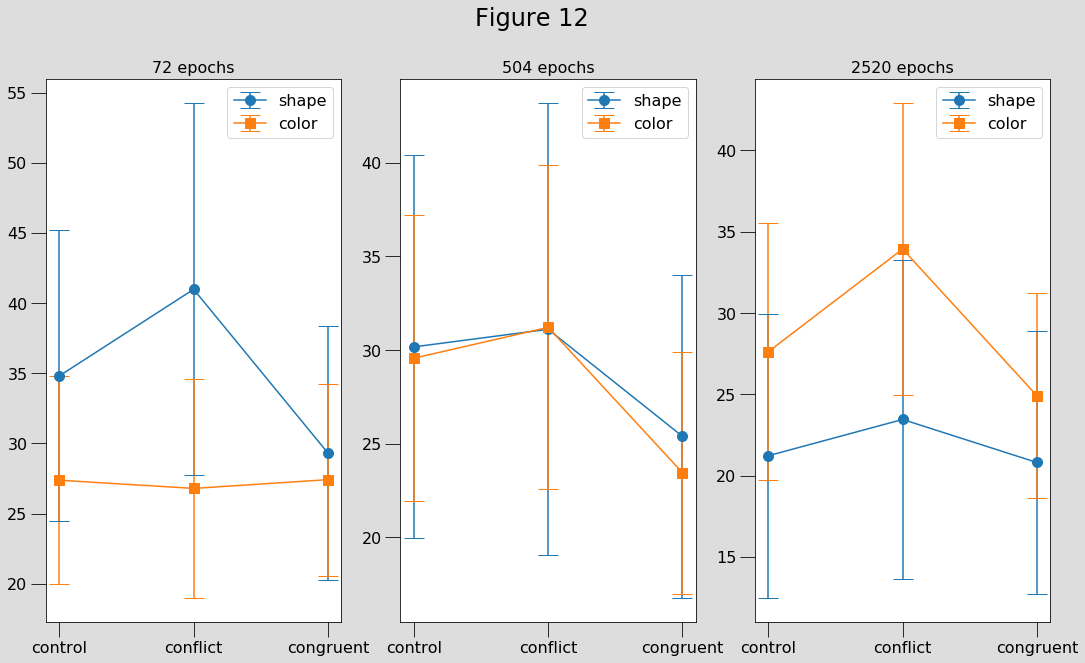

In [32]:
plot_by_condition(adj_indirect_day_one_results,
                 adj_indirect_day_five_results,
                 adj_indirect_day_twenty_results)

## Let's try with CHL!

In [53]:
hebbian_model = shape_naming_model.HebbianShapeNamingModel(
    direct_learning_rate=0.02, noise_std=0.01, integration_rate=0.2, accumulator_noise_std=0.01, 
    indirect_learning_rate=0.01, indirect_layer_size=6)

In [54]:
day_one_hebbian_results = day_one(hebbian_model)

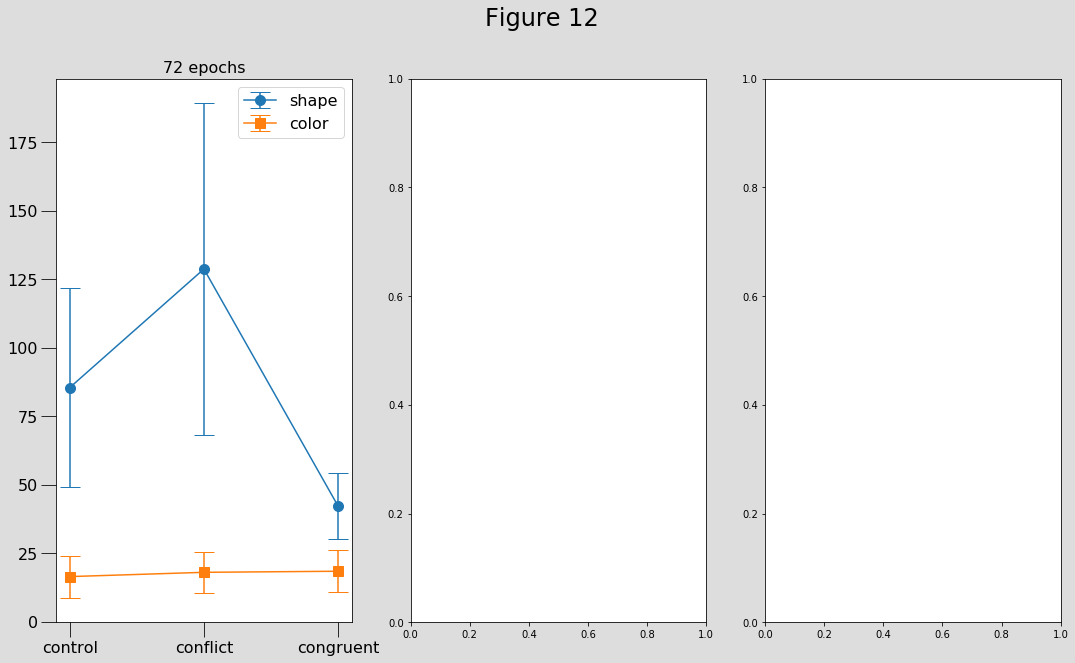

In [55]:
plot_by_condition(day_one_hebbian_results)

In [56]:
day_five_hebbian_results = day_five(hebbian_model)

TransferError: 'Maximum number of executions (1000) has occurred before reaching convergence_criterion (0.01) for ContrastiveHebbianMechanism-7 in trial 50 of run 6'

In [ ]:
plot_by_condition(day_one_hebbian_results,
                 day_five_hebbian_results)

In [96]:
log_dict = hebbian_model.indirect_shape_layer.log.nparray_dictionary()
layer_size = 10
arrays = [np.array([x[0] for x in log_dict[key]]) for key in ('Run', 'Trial', 'Pass', 'Time_step')]
arrays = [arr[:-1] for arr in arrays]
arrays.extend([np.squeeze(log_dict['value'][:, :, i]) for i in range(layer_size)])
table = np.stack(arrays, axis=1)

last_run = np.max(table[:, 0])
table = table[table[:, 0] == last_run]

# last_trial = np.max(table[:, 1])
# table = table[table[:, 1] == last_trial]

df = pandas.DataFrame(table, columns=['Run', 'Trial', 'Pass', 'Time_step'] +
                                                     [f'value-{i}' for i in range(layer_size)])

In [98]:
df[df.Trial == np.max(df.Trial) - 1]

,Run,Trial,Pass,Time_step,value-0,value-1,value-2,value-3,value-4,value-5,value-6,value-7,value-8,value-9
416,6.0,49.0,0.0,2.0,0.141851,0.858149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
417,6.0,49.0,1.0,2.0,0.141851,0.858149,0.016298,0.004631,-0.019282,-0.007661,-0.016621,-0.014338,0.010775,-0.001769
418,6.0,49.0,2.0,2.0,0.141851,0.858149,0.012371,0.007641,-0.020287,-0.010666,-0.011793,-0.011697,0.003553,0.012017
419,6.0,49.0,3.0,2.0,0.141851,0.858149,0.011826,0.009493,-0.020874,-0.015140,-0.016722,-0.020166,0.010073,0.012594
420,6.0,49.0,4.0,2.0,0.141851,0.858149,0.009934,0.011756,-0.023354,-0.017408,-0.014568,-0.018827,0.000000,1.000000
421,6.0,49.0,5.0,2.0,0.141851,0.858149,-0.114614,0.238268,-0.175187,-0.398571,-0.196022,-0.485252,0.000000,1.000000
422,6.0,49.0,6.0,2.0,0.141851,0.858149,-0.137331,0.270704,-0.183349,-0.468421,-0.219460,-0.517696,0.000000,1.000000
423,6.0,49.0,7.0,2.0,0.141851,0.858149,-0.142524,0.275960,-0.189521,-0.475548,-0.217956,-0.523713,0.000000,1.000000


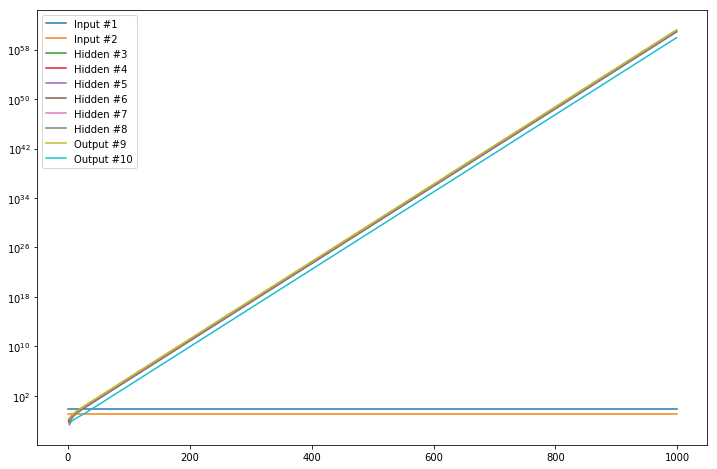

In [102]:
plt.figure(figsize=(12, 8))

fail_trial_df = df[df.Trial == np.max(df.Trial)]
passes = fail_trial_df['Pass']

for i in range(2):
    values = fail_trial_df[f'value-{i}']
    plt.plot(passes, values, label=f'Input #{i+1}')
    
for i in range(6):
    values = fail_trial_df[f'value-{i+2}']
    plt.plot(passes, values, label=f'Hidden #{i+3}')
    
for i in range(2):
    values = fail_trial_df[f'value-{i+8}']
    plt.plot(passes, values, label=f'Output #{i+9}')

plt.gca().set_yscale('log')
legend = plt.legend(loc='best')

    
plt.show()

In [85]:
log_dict['matrix'][-1001] == log_dict['matrix'][-1002]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True, False, False, False, False, False, False,
        False],
       [ True,  True, False,  True, False, False, False, False, False,
        False],
       [ True,  True, False, False,  True, False, False, False, False,
        False],
       [ True,  True, False, False, False,  True, False, False, False,
        False],
       [ True,  True, False, False, False, False,  True, False, False,
        False],
       [ True,  True, False, False, False, False, False,  True, False,
        False],
       [ True,  True, False, False, False, False, False, False,  True,
        False],
       [ True,  True, False, False, False, False, False, False, False,
         True]])

In [86]:
log_dict['matrix'][-1001]

array([[ 0.00000000e+00, -4.59053031e-03,  1.75900041e-02,
         8.00056590e-03, -1.93772691e-02, -1.79303966e-02,
        -8.06947781e-03, -2.08248395e-03,  1.83470175e-02,
        -1.05842807e-02],
       [-6.54950087e-03,  0.00000000e+00,  1.60843502e-02,
         4.07427541e-03, -1.92664140e-02, -5.96290873e-03,
        -1.80341830e-02, -1.63633578e-02,  9.52383061e-03,
        -3.12378672e-04],
       [ 4.17693291e-03, -1.65610834e-02,  0.00000000e+00,
        -7.76398277e-02,  1.00712146e-01,  8.03766986e-02,
        -9.01633918e-02, -5.36763717e-02, -3.15144662e-01,
        -1.42380850e-01],
       [-1.25178771e-02,  1.49882532e-02, -1.03009763e-01,
         0.00000000e+00, -1.10574223e-01, -9.83070449e-02,
         9.64213423e-02,  6.29558321e-03,  3.27687970e-01,
         2.40651930e-01],
       [-1.01354332e-02, -1.20901657e-02,  9.04198730e-02,
        -1.14538253e-01,  0.00000000e+00,  9.37594935e-02,
        -1.21908625e-01, -7.12667443e-02, -4.47799632e-01,
        -1.

In [87]:
log_dict['matrix'][-1002]

array([[ 0.00000000e+00, -4.59053031e-03,  1.75900041e-02,
         8.00056590e-03, -1.93772691e-02, -1.79303966e-02,
        -8.06947781e-03, -2.08248395e-03,  1.83470175e-02,
        -1.05842807e-02],
       [-6.54950087e-03,  0.00000000e+00,  1.60843502e-02,
         4.07427541e-03, -1.92664140e-02, -5.96290873e-03,
        -1.80341830e-02, -1.63633578e-02,  9.52383061e-03,
        -3.12378672e-04],
       [ 4.17693291e-03, -1.65610834e-02,  0.00000000e+00,
        -7.72285342e-02,  1.00451838e-01,  7.96660555e-02,
        -9.04739980e-02, -5.44535997e-02, -3.15160209e-01,
        -1.40856782e-01],
       [-1.25178771e-02,  1.49882532e-02, -1.02598470e-01,
         0.00000000e+00, -1.10124835e-01, -9.70802085e-02,
         9.69575650e-02,  7.63737022e-03,  3.27714810e-01,
         2.38020819e-01],
       [-1.01354332e-02, -1.20901657e-02,  9.01595654e-02,
        -1.14088864e-01,  0.00000000e+00,  9.29830290e-02,
        -1.22248000e-01, -7.21159612e-02, -4.47816619e-01,
        -1.

Text(0,0.5,'Weight')

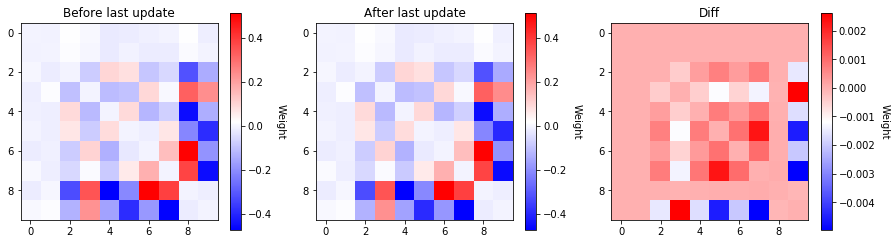

In [112]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 4))

ax1.set_title('Before last update')
im = ax1.imshow(log_dict['matrix'][-1002], cmap='bwr')
cbar1 = ax1.figure.colorbar(im, ax=ax1)
cbar1.ax.set_ylabel('Weight', rotation=-90, va="bottom")

ax2.set_title('After last update')
im = ax2.imshow(log_dict['matrix'][-1001], cmap='bwr')
cbar2 = ax2.figure.colorbar(im, ax=ax2)
cbar2.ax.set_ylabel('Weight', rotation=-90, va="bottom")

ax3.set_title('Diff')
im = ax3.imshow(log_dict['matrix'][-1001] - log_dict['matrix'][-1002], cmap='bwr')
cbar3 = ax3.figure.colorbar(im, ax=ax3)
cbar3.ax.set_ylabel('Weight', rotation=-90, va="bottom")